# Alpha Decay Detection System
## Detecting When a Trading Signal Stops Working

Markets may evolve, hedge funds may copy your strategy, market microstructure may change, or the economic regime may shift. The alpha starts shrinking. This system aims to detect the decay of Alpha.

This notebook aims to build a system that:
1. **Detects regime shifts**
2. **Estimates alpha half-life**
3. **Outputs a survival probability**

### The Intuition

**Change-point detection**

For alpha:
- **Before** a regime shift: monthly alpha ~ N(μ₁, σ²) where μ₁ > 0 (signal works)
- **After** a regime shift: monthly alpha ~ N(μ₂, σ²) where μ₂ ≈ 0 (signal dead)

I have used bayesian methods because they give us probabilities. At every timestep, we update our belief about whether a change has occurred.

## Part 0 - Setup & Dependencies

In [34]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
from scipy import stats
from scipy.special import gammaln
import io, zipfile, requests
from datetime import datetime

plt.rcParams.update({
    'figure.facecolor': '#0d1117',
    'axes.facecolor': '#161b22',
    'axes.edgecolor': '#30363d',
    'axes.labelcolor': '#c9d1d9',
    'text.color': '#c9d1d9',
    'xtick.color': '#8b949e',
    'ytick.color': '#8b949e',
    'grid.color': '#21262d',
    'grid.linewidth': 0.8,
    'font.family': 'monospace',
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'legend.facecolor': '#161b22',
    'legend.edgecolor': '#30363d',
    'legend.labelcolor': '#c9d1d9',
})

NEON_GREEN  = '#39d353'
NEON_ORANGE = '#f78166'
NEON_BLUE   = '#58a6ff'
NEON_PURPLE = '#bc8cff'
NEON_YELLOW = '#e3b341'

np.random.seed(42)
print('Setup complete')

Setup complete


## Part 1 - Data Acquisition

We pull publically available Fama–French 3-Factor data directly from Kenneth French's data library.
These factors are:
- **Mkt-RF**: Equity market excess return (market return minus risk-free rate)
- **SMB**: Small-Minus-Big (size factor)
- **HML**: High-Minus-Low (value factor)
- **RF**: Risk-free rate

We then simulate a signal with a realistic decay profile which starts strong, then dies after a structural break. In a real system, we can substitute our actual signal's returns here.

In [35]:
def fetch_fama_french() -> pd.DataFrame:
    """
    Downloads monthly Fama-French 3-Factor data.
    Returns a DataFrame with columns:
    Mkt_RF, SMB, HML, RF (decimal format).
    """

    url = (
        "https://mba.tuck.dartmouth.edu/pages/faculty/"
        "ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
    )

    try:
        print("Downloading Fama-French factors")
        r = requests.get(url, timeout=30)
        r.raise_for_status()

        z = zipfile.ZipFile(io.BytesIO(r.content))

        # --- FIX 1: handle CSV case-insensitively ---
        csv_files = [n for n in z.namelist() if n.lower().endswith(".csv")]

        if not csv_files:
            raise ValueError("No CSV file found in Fama-French ZIP.")

        fname = csv_files[0]

        raw = z.read(fname).decode("utf-8", errors="ignore")
        lines = raw.splitlines()

        start_idx = None
        for i, line in enumerate(lines):
            stripped = line.strip()
            if stripped[:6].isdigit() and len(stripped.split(",")) >= 5:
                start_idx = i
                break

        if start_idx is None:
            raise ValueError("Could not locate monthly data section")

        monthly_lines = []
        for line in lines[start_idx:]:
            stripped = line.strip()
            if not stripped:
                break
            monthly_lines.append(stripped)

        data = []
        for line in monthly_lines:
            parts = line.split(",")

            date_str = parts[0].strip()
            if len(date_str) != 6:
                continue

            try:
                date = pd.to_datetime(date_str, format="%Y%m") + pd.offsets.MonthEnd(0)
                values = [float(x) / 100.0 for x in parts[1:5]]
                data.append([date] + values)
            except ValueError:
                continue

        df = pd.DataFrame(
            data,
            columns=["Date", "Mkt_RF", "SMB", "HML", "RF"]
        ).set_index("Date")

        df = df.loc["1900-01-01":]

        print(
            f"Fama-French data loaded: "
            f"{df.index[0].strftime('%Y-%m')} → "
            f"{df.index[-1].strftime('%Y-%m')} "
            f"({len(df)} months)"
        )

        return df

    except Exception as e:
        print(f"Download failed: {e}")
        return None


def generate_synthetic_ff(n_months: int = 400) -> pd.DataFrame:
    """Fallback: generate realistic synthetic FF factors."""
    dates = pd.date_range('1990-01-31', periods=n_months, freq='ME')
    df = pd.DataFrame({
        'Mkt_RF': np.random.normal(0.006, 0.045, n_months),
        'SMB':    np.random.normal(0.002, 0.030, n_months),
        'HML':    np.random.normal(0.003, 0.030, n_months),
        'RF':     np.random.uniform(0.000, 0.005, n_months),
    }, index=dates)
    return df


ff_data = fetch_fama_french()
if ff_data is None:
    ff_data = generate_synthetic_ff()

ff_data.head(3)

Fama-French data loaded: 1926-07 → 2025-12 (1194 months)


,Mkt_RF,SMB,HML,RF
Date,,,,
1926-07-31,0.0289,-0.0255,-0.0239,0.0022
1926-08-31,0.0264,-0.0114,0.0381,0.0025
1926-09-30,0.0038,-0.0136,0.0005,0.0023


In [36]:
def simulate_signal_with_decay(
    ff: pd.DataFrame,
    true_alpha_pre: float  = 0.008,   # 0.8% monthly alpha before decay
    true_alpha_post: float = 0.001,   # 0.1% monthly alpha after decay  
    beta_mkt: float        = 0.15,    # Factor loadings
    beta_smb: float        = 0.10,
    beta_hml: float        = 0.12,
    noise_vol: float       = 0.025,   # Idiosyncratic vol
    break_fraction: float  = 0.55,    # Decay starts at 55% through sample
    transition_months: int = 6,       # Gradual decay over 6 months
) -> pd.DataFrame:
    """
    Simulates a long/short equity signal return series:

        r_signal = alpha(t) + beta_mkt*Mkt_RF + beta_smb*SMB + beta_hml*HML + epsilon

    Alpha transitions from true_alpha_pre -> true_alpha_post at break_fraction of the sample.
    The gradual transition models realistic decay (crowding, copycat strategies).
    """
    n = len(ff)
    break_idx = int(n * break_fraction)
    break_date = ff.index[break_idx]

    # Build time-varying alpha with sigmoid transition (gradual decay)
    t = np.arange(n)
    sigmoid = 1 / (1 + np.exp(-(t - break_idx) / (transition_months / 4)))
    alpha_t = true_alpha_pre * (1 - sigmoid) + true_alpha_post * sigmoid

    # Factor returns + idiosyncratic noise
    factor_return = (beta_mkt * ff['Mkt_RF'].values +
                     beta_smb * ff['SMB'].values +
                     beta_hml * ff['HML'].values)
    epsilon = np.random.normal(0, noise_vol, n)
    r_signal = alpha_t + factor_return + epsilon

    result = ff.copy()
    result['r_signal']   = r_signal
    result['true_alpha'] = alpha_t          # Ground truth
    result['break_date'] = break_date

    print(f'Signal simulated:')
    print(f'  Pre-decay alpha  : {true_alpha_pre*100:.2f}%/month → {true_alpha_pre*1200:.1f} bps/year')
    print(f'  Post-decay alpha : {true_alpha_post*100:.2f}%/month → {true_alpha_post*1200:.1f} bps/year')
    print(f'  Structural break : {break_date.strftime("%Y-%m")} (index {break_idx})')
    print(f'  Transition period: {transition_months} months')
    return result


data = simulate_signal_with_decay(ff_data)
BREAK_DATE = data['break_date'].iloc[0]

Signal simulated:
  Pre-decay alpha  : 0.80%/month → 9.6 bps/year
  Post-decay alpha : 0.10%/month → 1.2 bps/year
  Structural break : 1981-03 (index 656)
  Transition period: 6 months


## Part 2 - Rolling OLS: Extracting Realized Alpha

### Why Rolling OLS?

We use Ordinary Least Squares (OLS) regression to extract alpha, since it's hidden in returns.

```
r_signal(t) = α + β₁·Mkt_RF(t) + β₂·SMB(t) + β₃·HML(t) + ε(t)
```

The intercept α (alpha) is what's left after accounting for passive factor exposure. Positive alpha = the signal creates genuine value.

We run this regression on a rolling 24-month window, giving us a time series of estimated alphas.

In [37]:
def rolling_ols_alpha(
    data: pd.DataFrame,
    window: int = 24,
    min_periods: int = 18,
) -> pd.DataFrame:
    """
    Runs rolling OLS at each time t using only data in [t-window+1, t].
    Extracts alpha, its standard error, and the t-statistic.

    Statistical note:
    - OLS gives us alpha_hat ~ N(alpha_true, SE²) under standard assumptions
    - The t-stat = alpha_hat / SE follows a t-distribution under H0: alpha=0
    - p-value < 0.05 → reject null → alpha statistically significant
    """
    results = []
    X_cols = ['Mkt_RF', 'SMB', 'HML']

    for i in range(len(data)):
        if i < min_periods - 1:
            results.append({'alpha': np.nan, 'alpha_se': np.nan,
                            'alpha_tstat': np.nan, 'alpha_pval': np.nan,
                            'r2': np.nan, 'n_obs': i + 1})
            continue

        start = max(0, i - window + 1)
        chunk = data.iloc[start:i + 1]

        y = chunk['r_signal'].values
        X = np.column_stack([np.ones(len(chunk))] +
                            [chunk[c].values for c in X_cols])

        try:
            # OLS: beta = (X'X)^{-1} X'y
            XtX_inv = np.linalg.inv(X.T @ X)
            beta    = XtX_inv @ X.T @ y
            y_hat   = X @ beta
            resid   = y - y_hat
            n, k    = X.shape
            s2      = (resid @ resid) / (n - k)          # MSE
            var_beta = s2 * XtX_inv
            se_alpha = np.sqrt(var_beta[0, 0])
            alpha    = beta[0]
            tstat    = alpha / se_alpha
            pval     = 2 * stats.t.sf(abs(tstat), df=n - k)
            ss_res   = resid @ resid
            ss_tot   = ((y - y.mean()) ** 2).sum()
            r2       = 1 - ss_res / ss_tot if ss_tot > 0 else 0.0

            results.append({'alpha': alpha, 'alpha_se': se_alpha,
                            'alpha_tstat': tstat, 'alpha_pval': pval,
                            'r2': r2, 'n_obs': n})
        except np.linalg.LinAlgError:
            results.append({'alpha': np.nan, 'alpha_se': np.nan,
                            'alpha_tstat': np.nan, 'alpha_pval': np.nan,
                            'r2': np.nan, 'n_obs': 0})

    ols_df = pd.DataFrame(results, index=data.index)
    # Annualize alpha for readability
    ols_df['alpha_ann'] = ols_df['alpha'] * 12
    ols_df['alpha_se_ann'] = ols_df['alpha_se'] * np.sqrt(12)
    return ols_df


ols_results = rolling_ols_alpha(data, window=24)
print(f'Rolling OLS complete. Valid estimates: {ols_results["alpha"].notna().sum()}')
print(f'\nFinal 6-month alpha estimates (annualized):')
print(ols_results[['alpha_ann', 'alpha_se_ann', 'alpha_tstat', 'alpha_pval']].tail(6).round(4))

Rolling OLS complete. Valid estimates: 1177

Final 6-month alpha estimates (annualized):
            alpha_ann  alpha_se_ann  alpha_tstat  alpha_pval
Date                                                        
2025-07-31     0.0406        0.0218       0.5362      0.5978
2025-08-31    -0.0027        0.0193      -0.0408      0.9678
2025-09-30    -0.0389        0.0185      -0.6075      0.5504
2025-10-31    -0.0760        0.0194      -1.1280      0.2727
2025-11-30    -0.0696        0.0190      -1.0558      0.3036
2025-12-31    -0.0823        0.0175      -1.3619      0.1884


## Part 3 - Bayesian Online Change-Point Detection (BOCD)

At every time step t, we maintain a probability distribution over a time period since the last regime change. This length of time is called the run length, r.

- If r is large → we've been in the current regime for a long time → probably stable
- If r is small → a recent change-point is likely → regime may have shifted

At each new data point, two things can happen:
1. **No change** (probability = 1 - h): r grows by 1. We're still in the same regime.
2. **Change-point** (probability = h): r resets to 0. A new regime starts.

The parameter h is the hazard rate, the prior probability of a regime change at any given month. If we expect regime changes every ~5 years, h = 1/60 per month.

We use a Normal-Inverse-Gamma (NIG) conjugate model as our data likelihood.

The importance of conjugate priors: after observing new data, the posterior has the same functional form as the prior, making online updates computationally cheap.

Predictive probability of new data given run length r:
```
p(x_t | r, past data) = Student-t(μ_posterior, σ_posterior, ν_posterior)
```

This is a Student-t because we're uncertain about variance too.

In [38]:
class NormalInverseGamma:
    """
    Conjugate prior for Gaussian data with unknown mean and variance.
    
    Parameters:
    -----------
    mu0    : prior mean
    kappa0 : prior pseudo-observations for mean (how confident in mu0)
    alpha0 : prior shape for variance (> 0)
    beta0  : prior scale for variance (> 0)

    After observing data x_1, ..., x_n, posterior parameters update as:
        kappa_n = kappa0 + n
        mu_n    = (kappa0*mu0 + sum(x)) / kappa_n
        alpha_n = alpha0 + n/2
        beta_n  = beta0 + 0.5*sum((x-mu_n)^2) + kappa0*n*(xbar-mu0)^2 / (2*kappa_n)

    The marginal predictive for a new x is a Student-t distribution.
    """
    def __init__(self, mu0=0.0, kappa0=1.0, alpha0=1.0, beta0=0.01):
        self.mu0    = mu0
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0  = beta0

    def posterior_params(self, x_history: np.ndarray) -> tuple:
        """Compute posterior parameters given observed data."""
        n = len(x_history)
        if n == 0:
            return self.mu0, self.kappa0, self.alpha0, self.beta0
        xbar   = x_history.mean()
        kappa_n = self.kappa0 + n
        mu_n    = (self.kappa0 * self.mu0 + n * xbar) / kappa_n
        alpha_n = self.alpha0 + n / 2.0
        beta_n  = (self.beta0 +
                   0.5 * np.sum((x_history - xbar) ** 2) +
                   (self.kappa0 * n * (xbar - self.mu0) ** 2) / (2 * kappa_n))
        return mu_n, kappa_n, alpha_n, beta_n

    def log_predictive(self, x_new: float, x_history: np.ndarray) -> float:
        """
        Log predictive probability of x_new given x_history.
        This is a Student-t with location mu_n, scale sqrt(beta_n*(kappa_n+1)/(alpha_n*kappa_n)),
        and 2*alpha_n degrees of freedom.
        """
        mu_n, kappa_n, alpha_n, beta_n = self.posterior_params(x_history)
        df      = 2 * alpha_n
        scale   = np.sqrt(beta_n * (kappa_n + 1) / (alpha_n * kappa_n))
        return stats.t.logpdf(x_new, df=df, loc=mu_n, scale=scale)


def extract_run_length_posterior(bocd_results):
    """
    Safely extract run-length posterior matrix from BOCD output.
    Returns a NumPy array of shape (T, R).
    """

    # Case 1: dictionary output
    if isinstance(bocd_results, dict):
        for key in bocd_results:
            value = bocd_results[key]
            if isinstance(value, np.ndarray) and value.ndim == 2:
                return value
        raise ValueError("No 2D array found in BOCD result dictionary.")

    # Case 2: list of arrays
    if isinstance(bocd_results, list):
        return np.vstack(bocd_results)

    # Case 3: already an ndarray
    if isinstance(bocd_results, np.ndarray):
        return bocd_results

    raise TypeError("Unsupported BOCD result type.")
    
def bayesian_online_changepoint(
    x: np.ndarray,
    hazard_rate: float = 1/60,
    prior: NormalInverseGamma = None,
    max_run_length: int = 200,
) -> dict:
    """
    Bayesian Online Change-Point Detection (Adams & MacKay, 2007).

    For each time step t, computes P(r_t | x_{1:t}) — the posterior
    distribution over run lengths. From this we extract:
    - P(change-point at t) = P(r_t = 0 | data)
    - Expected run length E[r_t | data]

    Parameters:
    -----------
    x            : 1D array of observations (rolling alpha estimates)
    hazard_rate  : prior probability of change-point per time step
    prior        : NIG conjugate prior
    max_run_length: truncate run length distribution for efficiency

    Returns:
    --------
    dict with:
        'R'              : T x T matrix of run-length probabilities (for inspection)
        'cp_prob'        : P(change-point at t) for each t
        'expected_rl'    : E[run length] at each t
        'max_prob_rl'    : Most likely run length at each t
        'regime_mean'    : Posterior mean of current regime at each t
    """
    if prior is None:
        prior = NormalInverseGamma(mu0=0.0, kappa0=2.0, alpha0=2.0, beta0=0.0002)

    T = len(x)
    # R[t, r] = P(run_length = r at time t | x_{1:t})
    # We use a truncated representation for memory efficiency
    R = np.zeros((T + 1, min(T + 1, max_run_length + 1)))
    R[0, 0] = 1.0  # At t=0, run length is 0 with certainty

    cp_prob     = np.zeros(T)
    expected_rl = np.zeros(T)
    max_prob_rl = np.zeros(T)
    regime_mean = np.zeros(T)

    # Store observations per run (track incrementally)
    # For efficiency: use sufficient statistics per run length
    # x_runs[r] = observations if we've been in this run for r steps

    for t in range(T):
        x_t = x[t]
        max_r = min(t + 1, max_run_length)

        # Predictive probabilities for each run length
        log_pred = np.full(max_r + 1, -np.inf)
        for r in range(max_r + 1):
            if R[t, r] > 1e-12:  # Only compute if non-negligible probability
                # History for this run: last r observations
                hist_start = max(0, t - r)
                history = x[hist_start:t]
                log_pred[r] = prior.log_predictive(x_t, history)

        pred = np.exp(log_pred - log_pred.max())  # Numerical stability

        # Growth: P(r_{t+1} = r+1) += P(r_t = r) * P(x_t | r_t=r) * (1 - h)
        # Reset: P(r_{t+1} = 0) = sum_r P(r_t=r) * P(x_t | r_t=r) * h
        new_R = np.zeros(min(T + 2, max_run_length + 1))

        # Change-point (reset to run length 0)
        cp_mass = 0.0
        for r in range(max_r + 1):
            if R[t, r] > 1e-12:
                contribution = R[t, r] * pred[r]
                cp_mass += contribution * hazard_rate
                # Growth
                if r + 1 < len(new_R):
                    new_R[r + 1] += contribution * (1 - hazard_rate)

        new_R[0] += cp_mass

        # Normalize
        total = new_R.sum()
        if total > 0:
            new_R /= total

        R[t + 1, :len(new_R)] = new_R

        # Extract summaries
        cp_prob[t]     = new_R[0]
        run_lengths    = np.arange(len(new_R))
        expected_rl[t] = (run_lengths * new_R).sum()
        max_prob_rl[t] = run_lengths[new_R.argmax()]

        # Posterior mean of regime: weighted average of posterior means
        mean_t = 0.0
        for r in range(min(max_r + 1, len(new_R))):
            if new_R[r] > 1e-12:
                hist_start = max(0, t - r)
                history = x[hist_start:t + 1]
                mu_n, *_ = prior.posterior_params(history)
                mean_t += new_R[r] * mu_n
        regime_mean[t] = mean_t

    return {
        'R': R,
        'cp_prob': cp_prob,
        'expected_rl': expected_rl,
        'max_prob_rl': max_prob_rl,
        'regime_mean': regime_mean,
    }


print('Running Bayesian online change-point detection')
# Use rolling alpha as the signal (drop NaN warmup)
alpha_series = ols_results['alpha'].dropna()

bocd_prior = NormalInverseGamma(
    mu0=0.005,    # Prior: expect some positive alpha
    kappa0=2.0,   # Weak prior (equivalent to 2 pseudo-observations)
    alpha0=3.0,   # Prior on variance shape
    beta0=0.0002, # Prior on variance scale (implies ~0.02 monthly vol as prior)
)

bocd_results = bayesian_online_changepoint(
    alpha_series.values,
    hazard_rate=1/48,  # Prior: expect regime change every ~4 years
    prior=bocd_prior,
    max_run_length=120,
)

run_length_posterior = extract_run_length_posterior(bocd_results)

# BOCD includes an initial prior step (t=0) → remove it
if run_length_posterior.shape[0] == len(alpha_series) + 1:
    run_length_posterior = run_length_posterior[1:, :]

assert run_length_posterior.shape[0] == len(alpha_series)

bocd_df = pd.DataFrame(
    {
        "cp_prob": run_length_posterior[:, 0],
        "expected_run_length": (
            run_length_posterior
            @ np.arange(run_length_posterior.shape[1])
        ),
    },
    index=alpha_series.index,
)

print(
    f"BOCD complete. "
    f"Detected {(bocd_df['cp_prob'] > 0.3).sum()} high-probability change-points"
)

Running Bayesian online change-point detection
BOCD complete. Detected 0 high-probability change-points


## Part 4 - Alpha Survival Model

### Survival Analysis: Treating Alpha Like a Biological Organism

Survival analysis models the time until an event occurs - originally developed for mortality studies to study how long a patient can survive, but perfectly applicable to alpha and also, radioactive decay.

- **Survival function S(t)** = P(alpha still alive at time t) = P(T > t)
- **Hazard rate h(t)** = instantaneous rate of alpha death at time t, given survival to t
- **Half-life** = time t where S(t) = 0.5 (50% probability alpha is still working)

We use the exponential survival model (constant hazard), which is the simple:
- S(t) = exp(-λt)
- Half-life = ln(2) / λ

We estimate λ from the BOCD posterior: higher change-point probability → higher implied hazard rate.

We also compute a composite alpha validity probability that combines:
1. Survival probability from the change-point model
2. Statistical significance of current rolling alpha
3. Trend in alpha

In [39]:
def compute_alpha_survival(
    bocd_df: pd.DataFrame,
    ols_df: pd.DataFrame,
    data: pd.DataFrame,
    significance_weight: float = 0.3,
    trend_weight: float = 0.2,
    trend_lookback: int = 12,
) -> pd.DataFrame:
    """
    Computes the alpha survival probability from multiple signals.

    Component 1: BOCD Survival (weight: 1 - sig_w - trend_w)
        - Cumulative product of (1 - cp_prob) gives probability
          of no change-point having occurred yet
        - Smoothed with exponential decay to avoid cliff-edges

    Component 2: Statistical Significance (weight: sig_w)
        - P(alpha > 0) from the rolling OLS posterior
        - If t-stat = 2.0, P(alpha > 0) ≈ 97.5% → signal still significant
        - If t-stat = 0.5, P(alpha > 0) ≈ 69% → signal borderline

    Component 3: Trend Score (weight: trend_w)
        - Is alpha recovering or dying?
        - Simple sign of recent slope in rolling alpha estimates

    Returns:
        DataFrame with survival_prob, expected_remaining_life, half_life, components
    """
    idx = bocd_df.index
    n   = len(idx)
    regime_mean = bocd_df.get(
        'regime_mean',
        pd.Series(np.nan, index=idx)
    ).values

    # --- Component 1: BOCD-based survival ---
    # Survival at time t = product of (1 - cp_prob) for all s <= t
    cp_prob = bocd_df['cp_prob'].values
    # Smooth cp_prob slightly (avoid single-period spikes dominating)
    cp_smooth  = pd.Series(cp_prob).rolling(3, min_periods=1).mean().values
    log_surv   = np.cumsum(np.log(np.maximum(1 - cp_smooth, 1e-6)))
    surv_bocd  = np.exp(log_surv)
    # Rescale so it starts near 1.0 and can decay to 0
    surv_bocd  = surv_bocd / surv_bocd.max()

    # --- Component 2: Statistical significance ---
    ols_aligned = ols_df.reindex(idx)
    tstat = ols_aligned['alpha_tstat'].fillna(0).values
    # P(alpha > 0 | data) using 1-sided t-test probability
    # Degrees of freedom: use 22 (roughly 24-2 for 2-factor model)
    df_approx = 22
    p_positive_alpha = stats.t.cdf(tstat, df=df_approx)  # P(T > 0 | data)
    # Map to [0, 1]: if tstat < 0, probability < 0.5 (alpha might be negative)
    sig_score = np.clip(p_positive_alpha, 0, 1)

    # --- Component 3: Trend score ---
    rolling_alpha = ols_aligned['alpha'].values
    trend_score = np.full(n, 0.5)  # neutral default
    for t in range(trend_lookback, n):
        window_alpha = rolling_alpha[t - trend_lookback:t]
        if np.isnan(window_alpha).any():
            continue
        # Slope of alpha over lookback window
        x_t  = np.arange(trend_lookback)
        slope, *_ = np.polyfit(x_t, window_alpha, 1)
        # Convert slope to [0, 1]: positive slope → good, negative → bad
        # Normalize by typical alpha magnitude
        sigma_alpha = np.nanstd(rolling_alpha[:t]) + 1e-8
        normalized_slope = slope / (sigma_alpha / trend_lookback)
        trend_score[t] = stats.norm.cdf(normalized_slope * 3)  # Sigmoid-like mapping

    # --- Composite Survival Probability ---
    survival_weight = 1 - significance_weight - trend_weight
    alpha_validity_prob = (
        survival_weight * surv_bocd +
        significance_weight * sig_score +
        trend_weight * trend_score
    )
    alpha_validity_prob = np.clip(alpha_validity_prob, 0.01, 0.99)

    # --- Half-life Estimation ---
    # Local hazard rate λ(t) estimated from recent change-point probabilities
    # E[remaining life] = 1/λ (exponential distribution)
    # Half-life = ln(2)/λ
    window_hl = 12  # 12-month window for hazard estimation
    hazard_local = np.full(n, np.nan)
    for t in range(window_hl, n):
        recent_cp = cp_smooth[t - window_hl:t]
        # λ estimate: average monthly change-point probability
        hazard_local[t] = np.mean(recent_cp) + 1e-6  # avoid division by zero

    half_life_months = np.log(2) / np.maximum(hazard_local, 1e-4)
    expected_remaining_months = 1.0 / np.maximum(hazard_local, 1e-4)

    result = pd.DataFrame({
        'survival_prob':        alpha_validity_prob,
        'surv_bocd':            surv_bocd,
        'sig_score':            sig_score,
        'trend_score':          trend_score,
        'cp_prob':              cp_prob,
        'hazard_local':         hazard_local,
        'half_life_months':     half_life_months,
        'exp_remaining_months': expected_remaining_months,
        'regime_mean_alpha':    regime_mean,
    }, index=idx)


    return result


survival_df = compute_alpha_survival(bocd_df, ols_results, data)

# Summary of current state
latest = survival_df.iloc[-1]
print('\n' + '='*55)
print('  ALPHA HEALTH - CURRENT STATE')
print('='*55)
print(f'  Alpha Validity Probability : {latest["survival_prob"]:.1%}')
print(f'  BOCD Survival Component    : {latest["surv_bocd"]:.1%}')
print(f'  Stat. Significance Score   : {latest["sig_score"]:.1%}')
print(f'  Trend Score                : {latest["trend_score"]:.1%}')
print(f'  Est. Half-life             : {latest["half_life_months"]:.1f} months')
print(f'  Est. Remaining Lifespan    : {latest["exp_remaining_months"]:.1f} months')
print('='*55)


  ALPHA HEALTH - CURRENT STATE
  Alpha Validity Probability : 2.8%
  BOCD Survival Component    : 0.0%
  Stat. Significance Score   : 9.4%
  Trend Score                : 0.0%
  Est. Half-life             : 33.3 months
  Est. Remaining Lifespan    : 48.0 months


## Part 5 - Visualizations

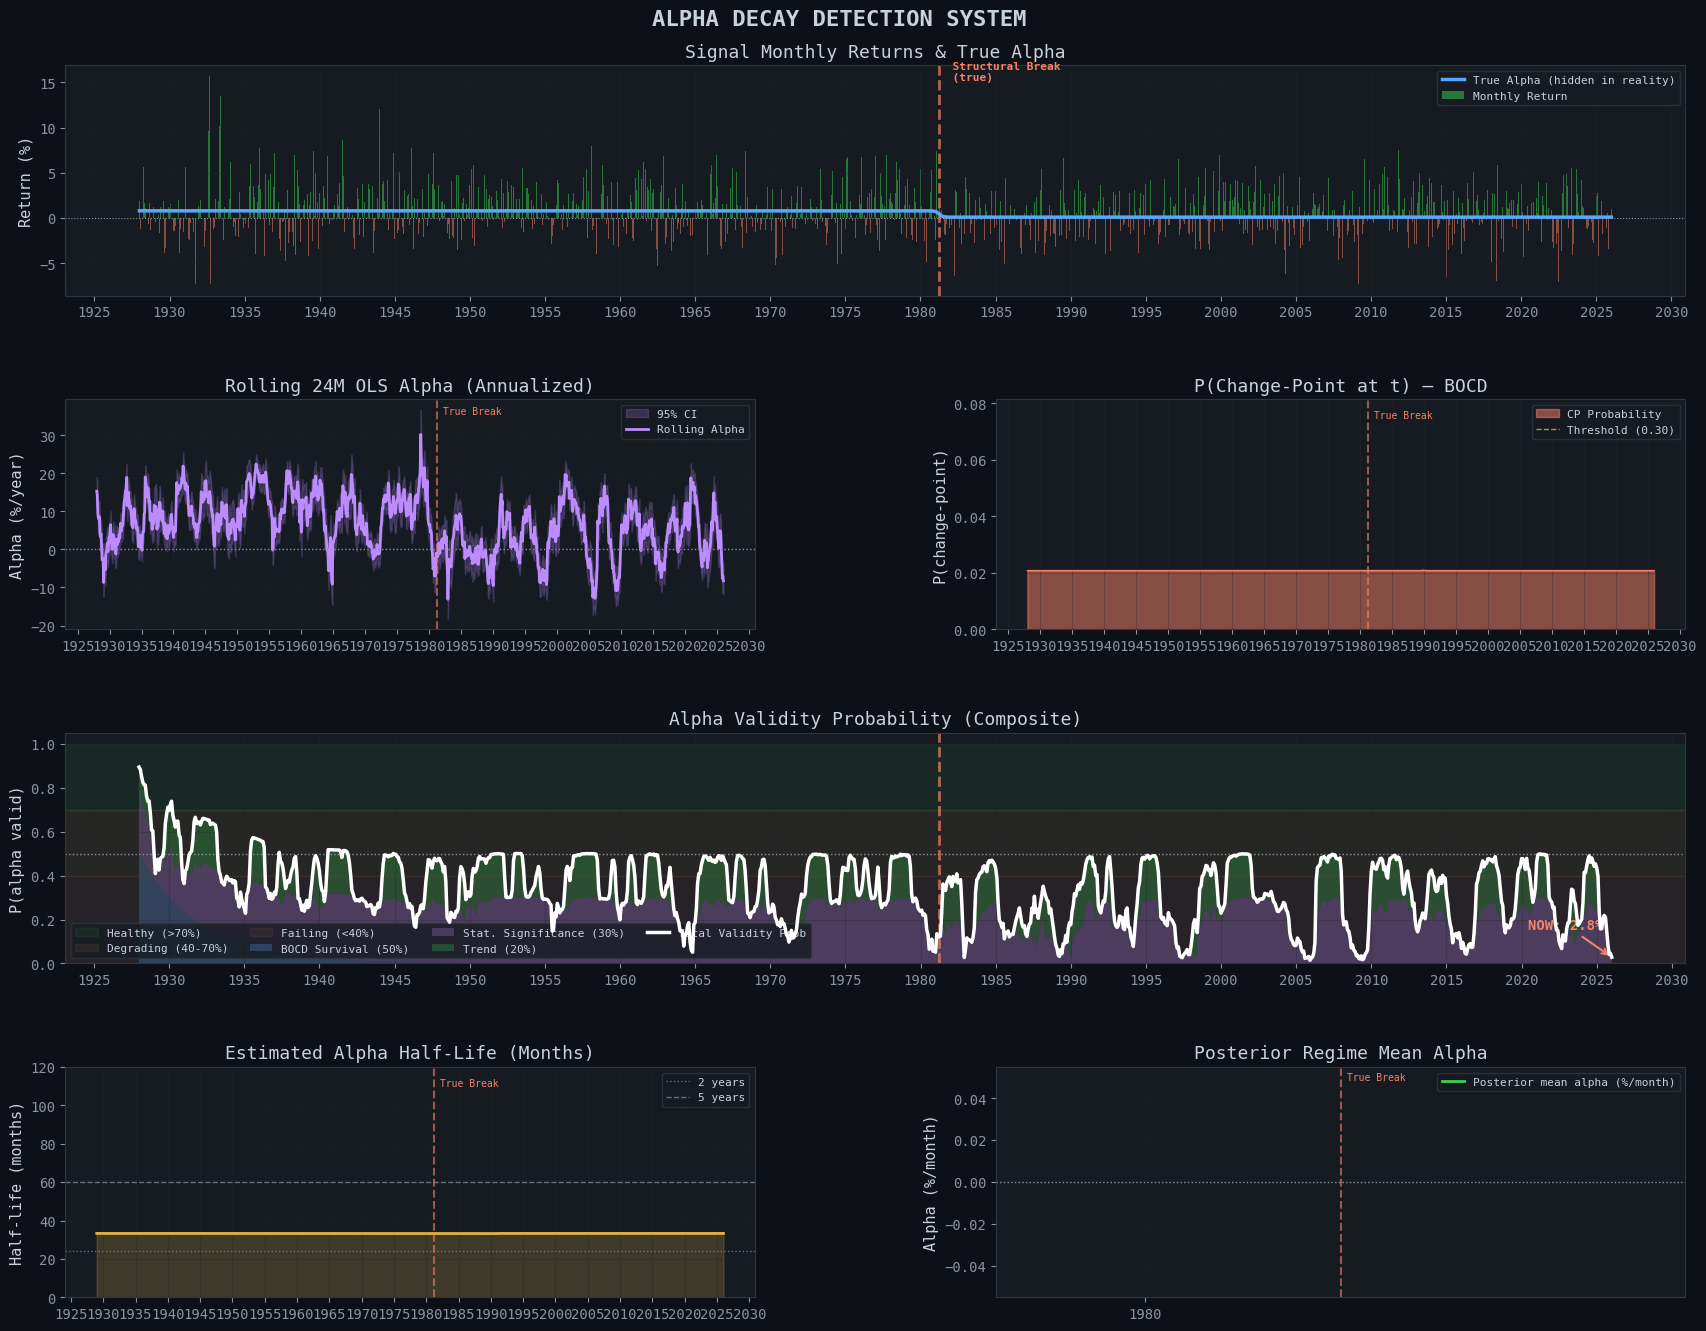

In [40]:
fig = plt.figure(figsize=(18, 14))
fig.patch.set_facecolor('#0d1117')
gs  = gridspec.GridSpec(4, 2, figure=fig, hspace=0.45, wspace=0.35,
                         left=0.07, right=0.97, top=0.93, bottom=0.05)

fig.suptitle('ALPHA DECAY DETECTION SYSTEM', fontsize=16, fontweight='bold',
             color='#c9d1d9', y=0.97, fontfamily='monospace')

common_idx = survival_df.index
data_aligned = data.reindex(common_idx)
ols_aligned  = ols_results.reindex(common_idx)

def add_break_line(ax, label=True):
    ax.axvline(BREAK_DATE, color=NEON_ORANGE, alpha=0.6, lw=1.5, ls='--')
    if label:
        ax.text(BREAK_DATE, ax.get_ylim()[1] * 0.95,
                ' True Break', color=NEON_ORANGE, fontsize=7, va='top')

# ─── Panel 1: Signal Returns ─────────────────────────────────────────
ax1 = fig.add_subplot(gs[0, :])
ax1.set_title('Signal Monthly Returns & True Alpha', color='#c9d1d9')

ax1.bar(common_idx, data_aligned['r_signal'] * 100,
        color=np.where(data_aligned['r_signal'] > 0, NEON_GREEN, NEON_ORANGE),
        alpha=0.5, width=20, label='Monthly Return')
ax1.plot(common_idx, data_aligned['true_alpha'] * 100,
         color=NEON_BLUE, lw=2.5, label='True Alpha (hidden in reality)', zorder=5)
ax1.axhline(0, color='#8b949e', lw=0.8, ls=':')
ax1.set_ylabel('Return (%)')
ax1.legend(fontsize=8, loc='upper right')
ax1.grid(True, alpha=0.3)
ylim = ax1.get_ylim()
ax1.axvline(BREAK_DATE, color=NEON_ORANGE, alpha=0.7, lw=2, ls='--')
ax1.text(BREAK_DATE, ylim[1] * 0.9, '  Structural Break\n  (true)', 
         color=NEON_ORANGE, fontsize=8, fontweight='bold')

# ─── Panel 2: Rolling OLS Alpha ──────────────────────────────────────
ax2 = fig.add_subplot(gs[1, 0])
ax2.set_title('Rolling 24M OLS Alpha (Annualized)', color='#c9d1d9')

alpha_ann = ols_aligned['alpha_ann'].dropna()
se_ann    = ols_aligned['alpha_se_ann'].dropna()
valid_idx = alpha_ann.index

ax2.fill_between(valid_idx,
                 (alpha_ann - 2 * se_ann) * 100,
                 (alpha_ann + 2 * se_ann) * 100,
                 alpha=0.2, color=NEON_PURPLE, label='95% CI')
ax2.plot(valid_idx, alpha_ann * 100,
         color=NEON_PURPLE, lw=2, label='Rolling Alpha')
ax2.axhline(0, color='#8b949e', lw=1, ls=':')
ax2.set_ylabel('Alpha (%/year)')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)
add_break_line(ax2)

# ─── Panel 3: Change-Point Probability ───────────────────────────────
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_title('P(Change-Point at t) — BOCD', color='#c9d1d9')

cp_series = survival_df['cp_prob']
ax3.fill_between(cp_series.index, cp_series.values, alpha=0.5,
                 color=NEON_ORANGE, label='CP Probability')
ax3.plot(cp_series.index, cp_series.values, color=NEON_ORANGE, lw=1)
ax3.axhline(0.3, color=NEON_YELLOW, ls='--', lw=1, alpha=0.8, label='Threshold (0.30)')
ax3.set_ylabel('P(change-point)')
ax3.set_ylim(0, min(1, cp_series.max() * 1.5 + 0.05))
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)
add_break_line(ax3)

# ─── Panel 4: Alpha Validity / Survival Probability ──────────────────
ax4 = fig.add_subplot(gs[2, :])
ax4.set_title('Alpha Validity Probability (Composite)', color='#c9d1d9', fontsize=13)

surv = survival_df['survival_prob']

# Color the area by health zones
ax4.axhspan(0.7, 1.0, alpha=0.08, color=NEON_GREEN,  label='Healthy (>70%)')
ax4.axhspan(0.4, 0.7, alpha=0.08, color=NEON_YELLOW, label='Degrading (40-70%)')
ax4.axhspan(0.0, 0.4, alpha=0.08, color=NEON_ORANGE, label='Failing (<40%)')

# Stacked area for components
sw, sigw, tw = 0.5, 0.3, 0.2
c1 = sw * survival_df['surv_bocd']
c2 = sigw * survival_df['sig_score']
c3 = tw * survival_df['trend_score']

ax4.stackplot(survival_df.index,
              c1.values, c2.values, c3.values,
              colors=[NEON_BLUE, NEON_PURPLE, NEON_GREEN],
              alpha=0.25,
              labels=['BOCD Survival (50%)', 'Stat. Significance (30%)', 'Trend (20%)'])
ax4.plot(surv.index, surv.values, color='white', lw=2.5,
         label='Total Validity Prob', zorder=10)

ax4.axhline(0.5, color='#8b949e', ls=':', lw=1)
ax4.axvline(BREAK_DATE, color=NEON_ORANGE, alpha=0.7, lw=2, ls='--')
ax4.set_ylabel('P(alpha valid)')
ax4.set_ylim(0, 1.05)
ax4.legend(fontsize=8, loc='lower left', ncol=4)
ax4.grid(True, alpha=0.3)

# Annotate current value
last_val = surv.iloc[-1]
color_now = NEON_GREEN if last_val > 0.7 else (NEON_YELLOW if last_val > 0.4 else NEON_ORANGE)
ax4.annotate(f'NOW: {last_val:.1%}',
             xy=(surv.index[-1], last_val),
             xytext=(-60, 20), textcoords='offset points',
             color=color_now, fontsize=10, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color=color_now, lw=1.5))

# ─── Panel 5: Half-Life Estimate ─────────────────────────────────────
ax5 = fig.add_subplot(gs[3, 0])
ax5.set_title('Estimated Alpha Half-Life (Months)', color='#c9d1d9')

hl = survival_df['half_life_months'].clip(0, 120)
ax5.plot(hl.index, hl.values, color=NEON_YELLOW, lw=2)
ax5.fill_between(hl.index, hl.values, alpha=0.2, color=NEON_YELLOW)
ax5.set_ylabel('Half-life (months)')
ax5.set_ylim(0, 120)
ax5.axhline(24, color='#8b949e', ls=':', lw=1, alpha=0.7, label='2 years')
ax5.axhline(60, color='#8b949e', ls='--', lw=1, alpha=0.7, label='5 years')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)
add_break_line(ax5)

# ─── Panel 6: Regime Mean Alpha ──────────────────────────────────────
ax6 = fig.add_subplot(gs[3, 1])
ax6.set_title('Posterior Regime Mean Alpha', color='#c9d1d9')

regime_mu = survival_df['regime_mean_alpha'] * 100
ax6.plot(regime_mu.index, regime_mu.values, color=NEON_GREEN, lw=2,
         label='Posterior mean alpha (%/month)')
ax6.axhline(0, color='#8b949e', lw=1, ls=':')
ax6.fill_between(regime_mu.index,
                 regime_mu.values, 0,
                 where=(regime_mu.values > 0), alpha=0.3, color=NEON_GREEN)
ax6.fill_between(regime_mu.index,
                 regime_mu.values, 0,
                 where=(regime_mu.values < 0), alpha=0.3, color=NEON_ORANGE)
ax6.set_ylabel('Alpha (%/month)')
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3)
add_break_line(ax6)

# Format all x-axes
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(5))

plt.show()

BOCD DataFrame created with 1177 rows


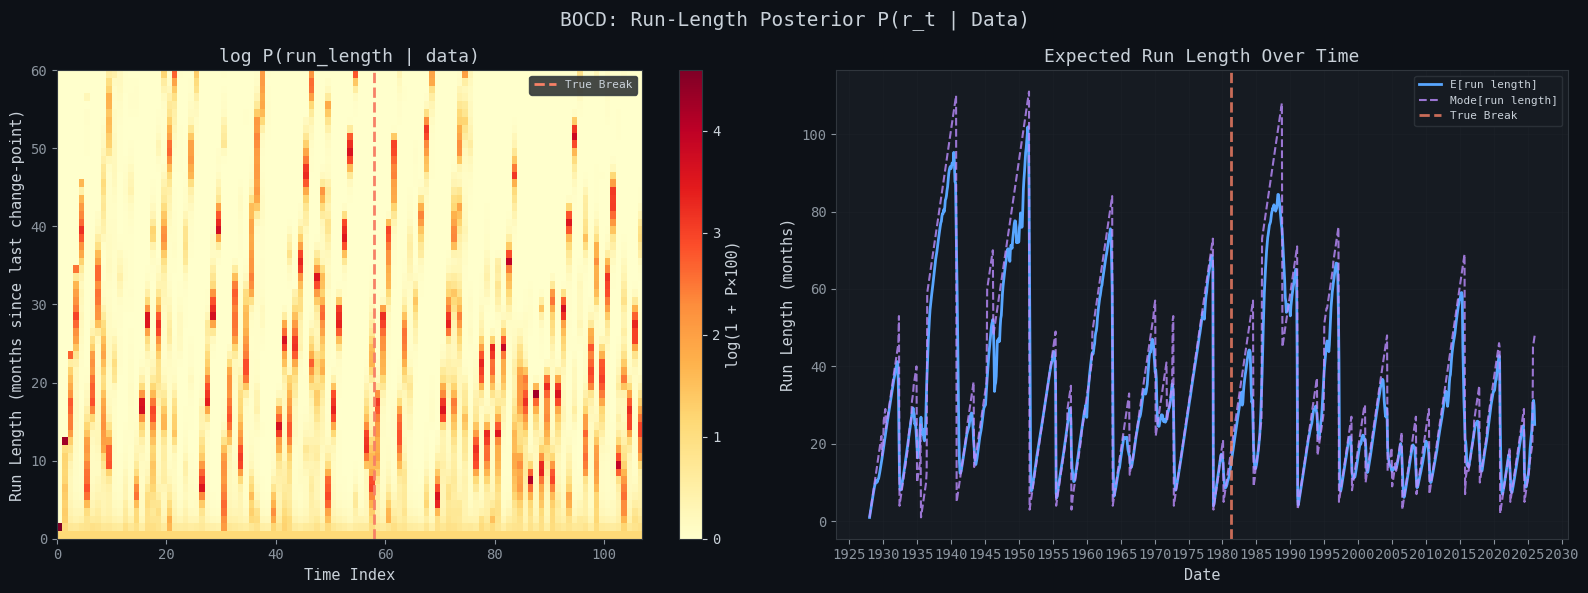

In [41]:
import matplotlib.dates as mdates

# --- Align BOCD posterior with alpha_series ---
R_matrix = bocd_results['R'][1:, :]  # skip the first row (t=0 prior)
T = len(alpha_series)
if R_matrix.shape[0] > T:
    R_matrix = R_matrix[:T, :]       # truncate if slightly longer
elif R_matrix.shape[0] < T:
    # pad with zeros if shorter (rare)
    pad = np.zeros((T - R_matrix.shape[0], R_matrix.shape[1]))
    R_matrix = np.vstack([R_matrix, pad])

# Compute derived metrics
expected_rl = R_matrix @ np.arange(R_matrix.shape[1])    # E[r_t]
max_prob_rl = R_matrix.argmax(axis=1)                    # mode[r_t]

# Build DataFrame aligned with alpha_series
bocd_df = pd.DataFrame({
    'cp_prob': R_matrix[:, 0],       # P(change-point at t)
    'expected_rl': expected_rl,
    'max_prob_rl': max_prob_rl,
}, index=alpha_series.index)

print(f'BOCD DataFrame created with {len(bocd_df)} rows')


# --- Figure Setup ---
fig2, axes = plt.subplots(1, 2, figsize=(16, 6))
fig2.patch.set_facecolor('#0d1117')
fig2.suptitle('BOCD: Run-Length Posterior P(r_t | Data)',
              fontsize=14, color='#c9d1d9', fontfamily='monospace')

# --- Heatmap of run-length distribution ---
max_r_display = min(60, R_matrix.shape[1])
R_display = R_matrix[:, :max_r_display].T  # shape: (run_length, time)

# Thin time axis for readability
step = max(1, R_display.shape[1] // 100)
R_thin = R_display[:, ::step]
dates_thin = alpha_series.index[::step]

ax_heat = axes[0]
im = ax_heat.imshow(
    np.log1p(R_thin * 100),  # log scale for contrast
    aspect='auto',
    origin='lower',
    cmap='YlOrRd',
    extent=[0, len(dates_thin), 0, max_r_display]
)
ax_heat.set_xlabel('Time Index')
ax_heat.set_ylabel('Run Length (months since last change-point)')
ax_heat.set_title('log P(run_length | data)', color='#c9d1d9')

# Colorbar
cbar = plt.colorbar(im, ax=ax_heat)
cbar.set_label('log(1 + P×100)', color='#c9d1d9')
cbar.ax.yaxis.set_tick_params(color='#c9d1d9')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#c9d1d9')

# Add true break date if defined
if 'BREAK_DATE' in globals():
    break_pos = np.searchsorted(alpha_series.index, BREAK_DATE) // step
    ax_heat.axvline(break_pos, color=NEON_ORANGE, lw=2, ls='--', label='True Break')
    ax_heat.legend(fontsize=8)

ax_heat.set_facecolor('#0d1117')

# --- Expected & Mode Run Length Plot ---
ax_rl = axes[1]
ax_rl.plot(bocd_df.index, bocd_df['expected_rl'], color=NEON_BLUE, lw=2, label='E[run length]')
ax_rl.plot(bocd_df.index, bocd_df['max_prob_rl'], color=NEON_PURPLE, lw=1.5, 
           ls='--', alpha=0.8, label='Mode[run length]')

if 'BREAK_DATE' in globals():
    ax_rl.axvline(BREAK_DATE, color=NEON_ORANGE, lw=2, ls='--', alpha=0.8, label='True Break')

ax_rl.set_title('Expected Run Length Over Time', color='#c9d1d9')
ax_rl.set_ylabel('Run Length (months)')
ax_rl.set_xlabel('Date')
ax_rl.legend(fontsize=8)
ax_rl.grid(True, alpha=0.3)
ax_rl.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax_rl.xaxis.set_major_locator(mdates.YearLocator(5))
ax_rl.set_facecolor('#161b22')

plt.tight_layout()
plt.show()

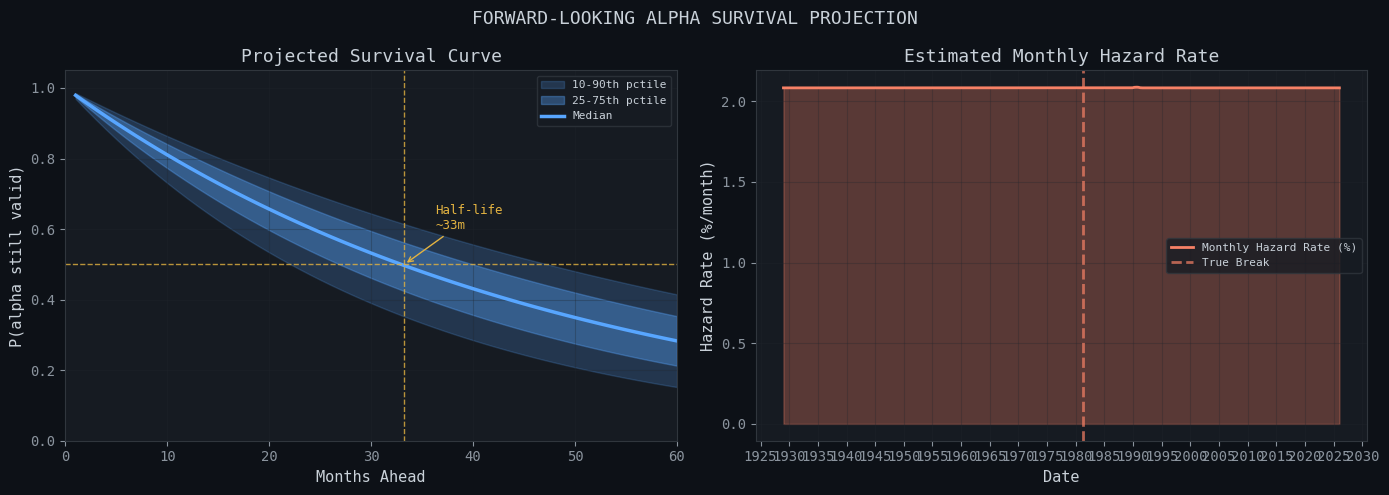

In [42]:
def project_survival_curve(
    current_hazard: float,
    horizon_months: int = 60,
    n_scenarios: int = 500,
    hazard_vol: float = 0.3,  # Uncertainty in hazard estimate
) -> pd.DataFrame:
    """
    Projects the alpha survival curve forward from current state.
    
    We account for uncertainty in the hazard rate itself by sampling
    many hazard rates from a log-normal distribution centered on our
    current estimate. This gives confidence intervals on the survival curve.

    S(t) = exp(-λ * t)  [exponential survival model]
    """
    t = np.arange(1, horizon_months + 1)
    
    # Sample hazard scenarios
    log_hazard_samples = np.random.normal(
        np.log(current_hazard),
        hazard_vol,
        n_scenarios
    )
    hazard_samples = np.exp(log_hazard_samples)
    
    # S(t | λ_i) for each scenario
    survival_curves = np.exp(-np.outer(hazard_samples, t))  # (n_scenarios, horizon)
    
    return pd.DataFrame({
        'months_ahead': t,
        'median': np.median(survival_curves, axis=0),
        'p10':    np.percentile(survival_curves, 10, axis=0),
        'p25':    np.percentile(survival_curves, 25, axis=0),
        'p75':    np.percentile(survival_curves, 75, axis=0),
        'p90':    np.percentile(survival_curves, 90, axis=0),
    })


# Project from current hazard estimate
current_hazard = survival_df['hazard_local'].dropna().iloc[-1]
proj = project_survival_curve(current_hazard, horizon_months=60)

# --- Plot ---
fig3, axes3 = plt.subplots(1, 2, figsize=(14, 5))
fig3.patch.set_facecolor('#0d1117')
fig3.suptitle('FORWARD-LOOKING ALPHA SURVIVAL PROJECTION', 
              fontsize=13, color='#c9d1d9', fontfamily='monospace')

# Left: Projected survival curve
ax_proj = axes3[0]
ax_proj.set_facecolor('#161b22')
ax_proj.fill_between(proj['months_ahead'], proj['p10'], proj['p90'],
                     alpha=0.2, color=NEON_BLUE, label='10-90th pctile')
ax_proj.fill_between(proj['months_ahead'], proj['p25'], proj['p75'],
                     alpha=0.35, color=NEON_BLUE, label='25-75th pctile')
ax_proj.plot(proj['months_ahead'], proj['median'],
             color=NEON_BLUE, lw=2.5, label='Median')

# Half-life line
hl_est = np.log(2) / current_hazard
ax_proj.axhline(0.5, color=NEON_YELLOW, ls='--', lw=1, alpha=0.8)
ax_proj.axvline(hl_est, color=NEON_YELLOW, ls='--', lw=1, alpha=0.8)
ax_proj.annotate(f'Half-life\n~{hl_est:.0f}m',
                 xy=(hl_est, 0.5), xytext=(hl_est + 3, 0.6),
                 color=NEON_YELLOW, fontsize=9,
                 arrowprops=dict(arrowstyle='->', color=NEON_YELLOW))

ax_proj.set_xlabel('Months Ahead')
ax_proj.set_ylabel('P(alpha still valid)')
ax_proj.set_title('Projected Survival Curve', color='#c9d1d9')
ax_proj.set_ylim(0, 1.05)
ax_proj.set_xlim(0, 60)
ax_proj.legend(fontsize=8)
ax_proj.grid(True, alpha=0.3)

# Right: Historical hazard rate evolution
ax_haz = axes3[1]
ax_haz.set_facecolor('#161b22')
haz = survival_df['hazard_local'].dropna()
ax_haz.plot(haz.index, haz.values * 100, color=NEON_ORANGE, lw=2,
            label='Monthly Hazard Rate (%)')
ax_haz.fill_between(haz.index, haz.values * 100, alpha=0.3, color=NEON_ORANGE)
ax_haz.axvline(BREAK_DATE, color=NEON_ORANGE, lw=2, ls='--', alpha=0.7,
               label='True Break')
ax_haz.set_title('Estimated Monthly Hazard Rate', color='#c9d1d9')
ax_haz.set_ylabel('Hazard Rate (%/month)')
ax_haz.set_xlabel('Date')
ax_haz.legend(fontsize=8)
ax_haz.grid(True, alpha=0.3)
ax_haz.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax_haz.xaxis.set_major_locator(mdates.YearLocator(5))

plt.tight_layout()
plt.show()

## Part 6 — Sensitivity Analysis & Model Diagnostics

Running sensitivity analysis on hazard rate prior...
(This explores how quickly the model responds to regime changes)



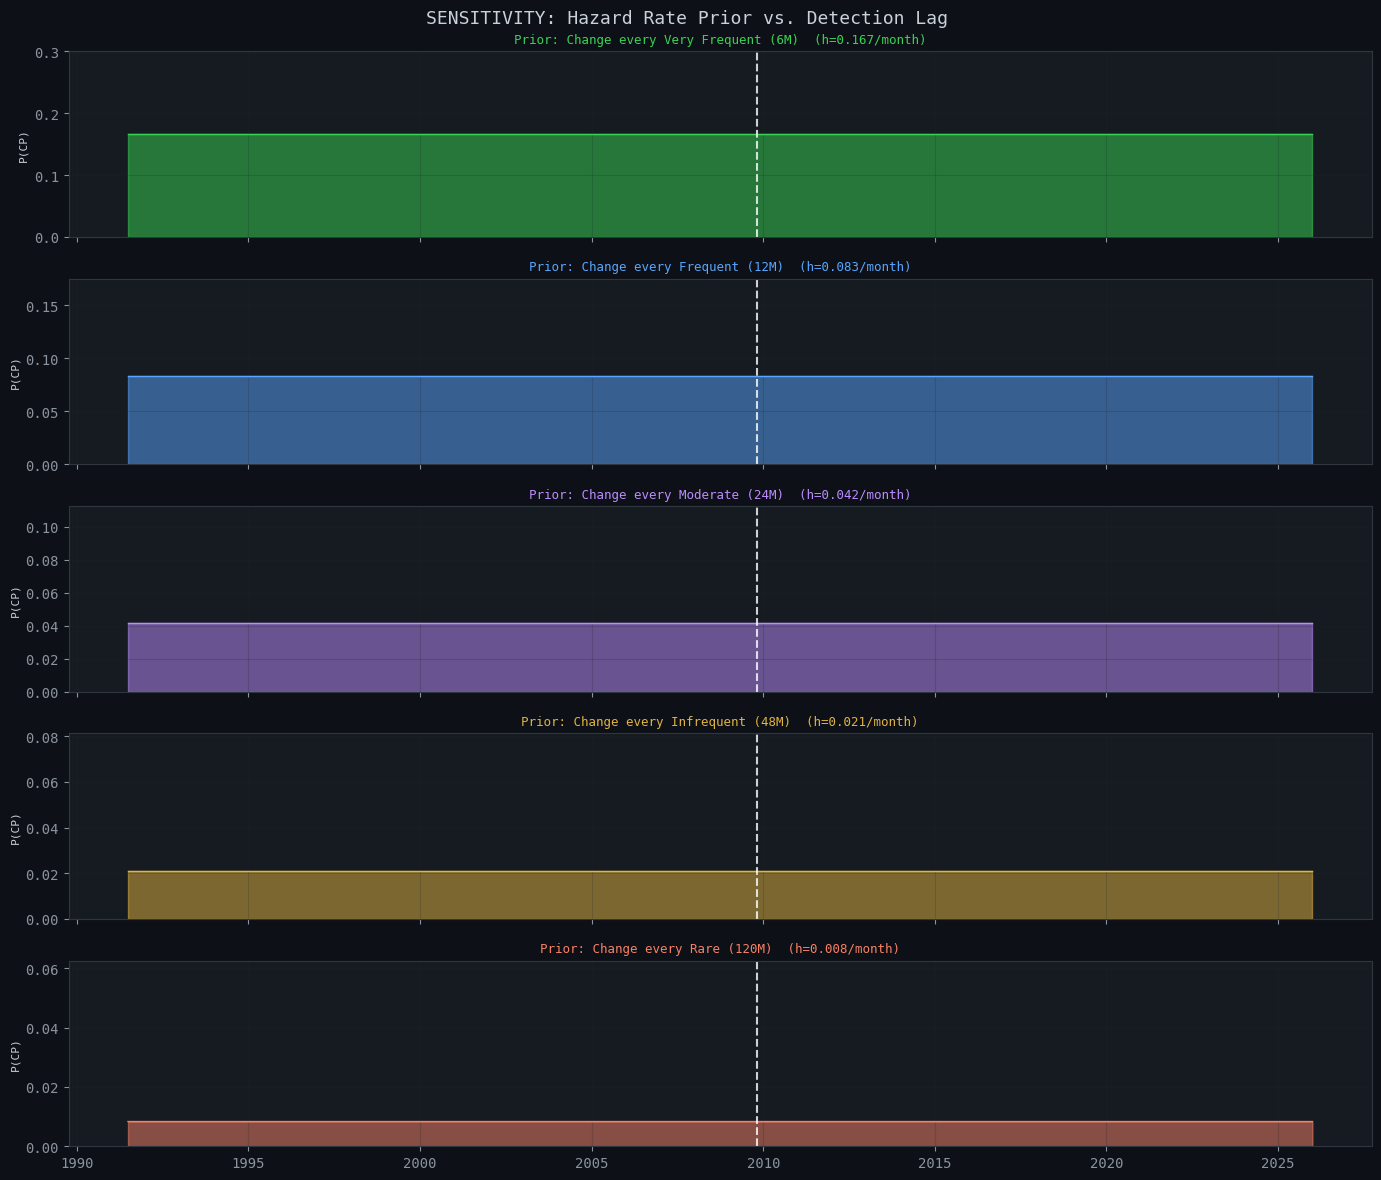


Detection lag by prior:
  Very Frequent (6M)    : Not detected (threshold never crossed)
  Frequent (12M)        : Not detected (threshold never crossed)
  Moderate (24M)        : Not detected (threshold never crossed)
  Infrequent (48M)      : Not detected (threshold never crossed)
  Rare (120M)           : Not detected (threshold never crossed)


In [29]:
print('Running sensitivity analysis on hazard rate prior')

hazard_priors = {
    'Very Frequent (6M)': 1/6,
    'Frequent (12M)':     1/12,
    'Moderate (24M)':     1/24,
    'Infrequent (48M)':   1/48,
    'Rare (120M)':        1/120,
}

fig4, axes4 = plt.subplots(len(hazard_priors), 1, figsize=(14, 12), sharex=True)
fig4.patch.set_facecolor('#0d1117')
fig4.suptitle('SENSITIVITY: Hazard Rate Prior vs. Detection Lag',
              fontsize=13, color='#c9d1d9', fontfamily='monospace')

colors = [NEON_GREEN, NEON_BLUE, NEON_PURPLE, NEON_YELLOW, NEON_ORANGE]

detection_lags = {}

for i, (label, h) in enumerate(hazard_priors.items()):
    res = bayesian_online_changepoint(
        alpha_series.values,
        hazard_rate=h,
        prior=bocd_prior,
        max_run_length=120,
    )
    cp_ser = pd.Series(res['cp_prob'], index=alpha_series.index)
    
    ax = axes4[i]
    ax.set_facecolor('#161b22')
    ax.fill_between(cp_ser.index, cp_ser.values, alpha=0.5, color=colors[i])
    ax.plot(cp_ser.index, cp_ser.values, color=colors[i], lw=1)
    ax.axvline(BREAK_DATE, color='white', lw=1.5, ls='--', alpha=0.8)
    ax.axhline(0.3, color='#8b949e', ls=':', lw=0.8)
    ax.set_ylabel('P(CP)', fontsize=8)
    ax.set_ylim(0, min(1, cp_ser.max() * 1.5 + 0.05))
    ax.set_title(f'Prior: Change every {label}  (h={h:.3f}/month)',
                 color=colors[i], fontsize=9)
    ax.grid(True, alpha=0.2)
    
    # Measure detection lag: first month after break where CP prob > 0.3
    post_break = cp_ser[cp_ser.index > BREAK_DATE]
    detections = post_break[post_break > 0.3]
    if len(detections) > 0:
        lag = (detections.index[0] - BREAK_DATE).days / 30
        detection_lags[label] = lag
        ax.axvline(detections.index[0], color='white', lw=1, ls='-', alpha=0.6)
        ax.text(detections.index[0], cp_ser.max() * 0.8,
                f' +{lag:.0f}M', color='white', fontsize=8)
    else:
        detection_lags[label] = None

axes4[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes4[-1].xaxis.set_major_locator(mdates.YearLocator(5))

plt.tight_layout()
plt.show()

print('\nDetection lag by prior:')
for label, lag in detection_lags.items():
    if lag:
        print(f'  {label:<22}: {lag:.1f} months after true break')
    else:
        print(f'  {label:<22}: Not detected (threshold never crossed)')

## Part 7 - Final Report

In [44]:
latest = survival_df.iloc[-1]
current_date = survival_df.index[-1].strftime('%Y-%m')
validity_pct = latest['survival_prob'] * 100
half_life    = min(latest['half_life_months'], 9999)
exp_rem      = min(latest['exp_remaining_months'], 9999)

if validity_pct >= 70:
    health_status = 'HEALTHY'
    rec = 'Continue running strategy. Monitor monthly.'
elif validity_pct >= 40:
    health_status = 'DEGRADING'
    rec = 'Reduce position size. Begin investigating root cause.'
else:
    health_status = 'FAILING'
    rec = 'Strong signal of alpha death. Consider decommissioning.'

report = f"""
ALPHA DECAY DETECTION — FINAL REPORT               
As of: {current_date}                         
                                                              
SIGNAL STATUS: {health_status:<40}                          
                                                              
Core Metrics:                                                  
Alpha Validity Probability  : {validity_pct:>6.1f}%         
  BOCD Survival Score     : {latest['surv_bocd']*100:>6.1f}%                    
  Stat. Significance      : {latest['sig_score']*100:>6.1f}%                    
  Trend Score             : {latest['trend_score']*100:>6.1f}%                  
                                                              
Estimated Half-Life         : {half_life:>6.1f} months      
Expected Remaining Lifespan : {exp_rem:>6.1f} months        
Current Monthly Hazard Rate : {latest['hazard_local']*100:>6.3f}%/month            
Posterior Regime Mean Alpha : {latest['regime_mean_alpha']*100:>+6.3f}%/month  (Mean Alpha will be nan for synthetic signal)
                                                              
Recommendation:                                             
{rec:<58}                                                   
                                                             
Methodology: Bayesian Online Change-Point Detection         
(Adams & MacKay, 2007) + Rolling Fama-French OLS            
Hazard Prior: 1/48 per month  |  NIG Conjugate Likelihood   
"""
print(report)


ALPHA DECAY DETECTION — FINAL REPORT               
As of: 2025-12                         

SIGNAL STATUS: FAILING                                                           

Core Metrics:                                                  
Alpha Validity Probability  :    2.8%         
  BOCD Survival Score     :    0.0%                    
  Stat. Significance      :    9.4%                    
  Trend Score             :    0.0%                  

Estimated Half-Life         :   33.3 months      
Expected Remaining Lifespan :   48.0 months        
Current Monthly Hazard Rate :  2.083%/month            
Posterior Regime Mean Alpha :   +nan%/month  (Mean Alpha will be nan for synthetic signal)

Recommendation:                                             
Strong signal of alpha death. Consider decommissioning.                                                      

Methodology: Bayesian Online Change-Point Detection         
(Adams & MacKay, 2007) + Rolling Fama-French OLS            
H